# **Challenge Valhalla**
**Rogelio Lizárraga Escobar A01742161**

## Importamos las librerías

In [150]:
from sklearn.linear_model import SGDRegressor
import random
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [151]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/gdrive')
data = pd.read_csv('/content/gdrive/MyDrive/Valhalla23.csv')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [152]:
seed = 2161

# Hacemos un split de 40% train, 40% valid y 20% test y estandarizamos los datos

In [153]:
df = pd.DataFrame(data)
y = df[['Valks']].to_numpy()
X = df[['Celsius']].to_numpy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_tout, X_test, y_tout, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_tout, y_tout, test_size=0.5, random_state=seed)
sgd = SGDRegressor(learning_rate='constant', eta0=1e-4, max_iter=1_000_000, random_state=seed)


## Realizaremos un GridSearch para encontrar los mejores parámetros para SGDRegressor

In [154]:
hyper_grid_sgd = {
    'sgdregressor__penalty': ['l2', 'l1', 'elasticnet'],
    'sgdregressor__l1_ratio': np.linspace(0, 1, 10)
}

pipeline = make_pipeline(sgd)
sgd_grid = GridSearchCV(pipeline, hyper_grid_sgd, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
sgd_grid.fit(X_train, y_train.ravel())

best_penalty_sgd = sgd_grid.best_params_['sgdregressor__penalty']
best_l1_ratio_sgd = sgd_grid.best_params_.get('sgdregressor__l1_ratio', None)
final_sgd = SGDRegressor(alpha=1e-4, penalty=best_penalty_sgd, l1_ratio=best_l1_ratio_sgd, max_iter=1000000)
final_pipeline = make_pipeline(final_sgd)
final_pipeline.fit(X_train, y_train.ravel())

Pipeline(steps=[('sgdregressor',
                 SGDRegressor(l1_ratio=0.3333333333333333, max_iter=1000000,
                              penalty='elasticnet'))])

In [155]:
# Ajustar el modelo con los mejores hiperparámetros
final_pipeline.fit(X_train, y_train.ravel())

# MSE en Entrenamiento
sgd_train_pred = final_pipeline.predict(X_train)
sgd_train_mse = round(mean_squared_error(y_train, sgd_train_pred), 4)

# MSE en Validación (GridSearchCV)
mse_scores = -sgd_grid.cv_results_['mean_test_score']
mse_validation = round(mse_scores[sgd_grid.best_index_], 4)

# MSE en Prueba
sgd_pred = final_pipeline.predict(X_test)
sgd_mse = round(mean_squared_error(y_test, sgd_pred), 4)




sgd_r2 = round(r2_score(y_test, sgd_pred), 4)

print("---------------------------------------------------------")
print(f"MSE Entrenamiento SGDRegressor: {sgd_train_mse}")
print(f"MSE Validación SGDRegressor: {mse_validation}")
print(f"MSE Prueba SGDRegressor: {sgd_mse}")
print(f"Coeficiente de determinación de SGDRegressor (R^2): {sgd_r2}")

---------------------------------------------------------
MSE Entrenamiento SGDRegressor: 36.8115
MSE Validación SGDRegressor: 40.1884
MSE Prueba SGDRegressor: 38.7197
Coeficiente de determinación de SGDRegressor (R^2): 0.996


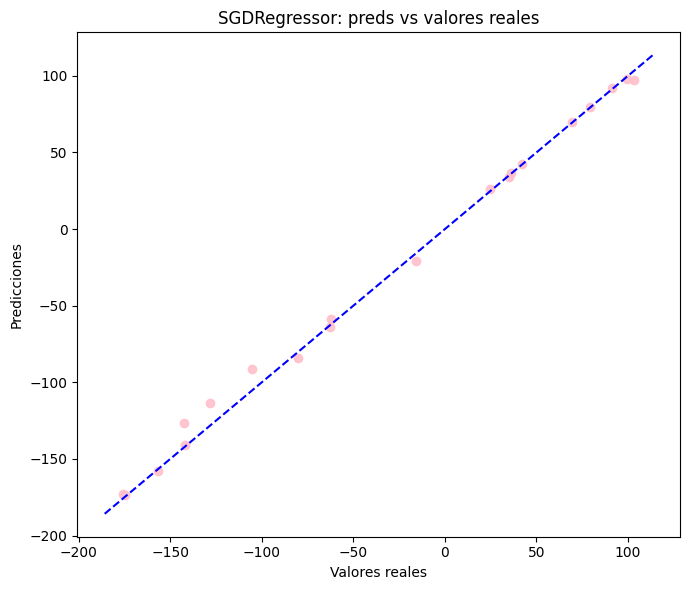

In [156]:
plt.figure(figsize=(7, 6))
plt.scatter(y_test, sgd_pred, alpha=0.9, color='pink')
plt.plot([y_test.min()-10, y_test.max()+10], [y_test.min()-10, y_test.max()+10], 'b--')
plt.title('SGDRegressor: preds vs valores reales')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.tight_layout()
plt.show()


# Generamos la lista de los 20 elementos

In [157]:
random.seed(seed)
sizes = random.sample(range(3, 40), 19, )
sizes.append(2)
sizes.sort()
print(sizes)


[2, 3, 4, 8, 9, 10, 11, 12, 17, 19, 20, 21, 23, 25, 27, 30, 32, 35, 36, 37]


# Entrenamiendo de las muestras

In [158]:
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error

train_errors = []
val_errors = []

for size in sizes:
    train_mse_list = []
    val_mse_list = []

    for _ in range(100):
        X_train_sub, y_train_sub = resample(X_train, y_train, n_samples=size, random_state=seed)
        final_sgd.fit(X_train_sub, y_train_sub.ravel())
        train_pred = final_sgd.predict(X_train_sub)
        train_mse = mean_squared_error(y_train_sub, train_pred)
        val_pred = final_sgd.predict(X_valid)
        val_mse = mean_squared_error(y_valid, val_pred)
        train_mse_list.append(train_mse)
        val_mse_list.append(val_mse)
    avg_train_mse = np.mean(train_mse_list)
    avg_val_mse = np.mean(val_mse_list)

    train_errors.append(avg_train_mse)
    val_errors.append(avg_val_mse)


In [159]:
train_errors

[0.40673745039219367,
 3.579448530954776,
 2.8627665945152625,
 3.276754121016856,
 3.047180146429217,
 3.470758405298874,
 3.626431483335169,
 3.372031132089624,
 20.798988674068195,
 18.663850453229404,
 18.083635939265875,
 17.264884140351878,
 16.556036357192156,
 28.499567287335477,
 26.764981759615484,
 24.81440941286331,
 25.206225805221116,
 23.358870702196974,
 23.02954367739117,
 22.64566491591796]

In [160]:
final_sgd.fit(X_train, y_train.ravel()) # Entrenamos el modelo del conjunto total

train_pred_full = final_sgd.predict(X_train) # Calculamos ambos errores de línea base
val_pred_full = final_sgd.predict(X_valid)

train_mse_base = mean_squared_error(y_train, train_pred_full)
val_mse_base = mean_squared_error(y_valid, val_pred_full)
train_errors.append(train_mse_base)
val_errors.append(val_mse_base)
sizes = np.append(sizes, X_train.shape[0])


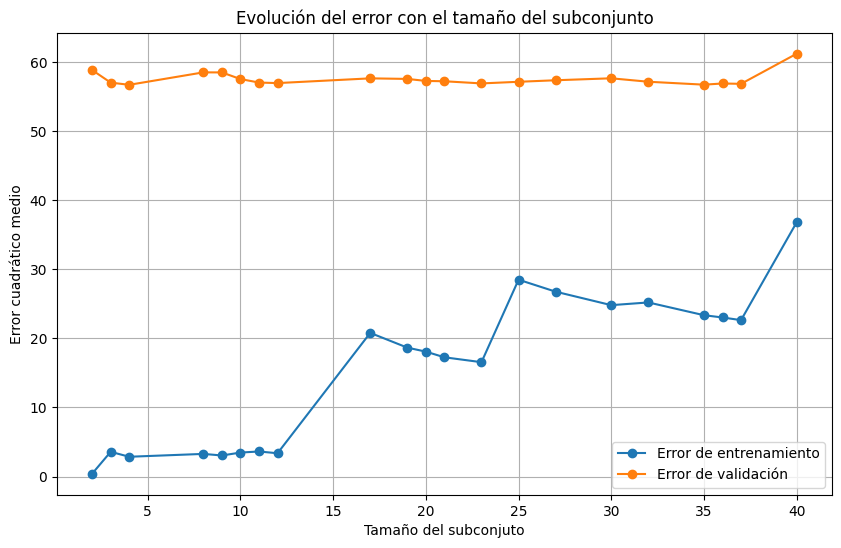

In [161]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(sizes, train_errors, marker='o', label='Error de entrenamiento')
plt.plot(sizes, val_errors, marker='o', label='Error de validación')
plt.xlabel('Tamaño del subconjuto')
plt.ylabel('Error cuadrático medio')
plt.title('Evolución del error con el tamaño del subconjunto')
plt.legend()
plt.grid(True)
plt.show()


In [162]:
train_errors[1]

3.579448530954776

In [163]:
train_errors[-1]

36.81127972718592

In [164]:
x = min(val_errors)
y = 0
for i in range (0, len(sizes)):
  if val_errors[i] == x:
    print(f'Error de validación mínimo: {x} en la posición {i}')
    y = sizes[i]

Error de validación mínimo: 56.71823638913995 en la posición 2


In [165]:
y

4

Observamos cómo el error de entrenamiento va aumentando conforme el tamaño de la muestra cambia. Por ejemplo, para n=2, el error es 3.58 y para n=40 el error es 36.81.
Esto es debido a que el MSE depende de la cantidad de datos que haya. Es decir, entre más datos, mayor el error.

Por otro lado, el conjunto de validación mantiene prácticamente el mismo error para todos los datos, siendo mínimo el de la n = 4, con valor de $\approx$ 56.72. Sin embargo, esto es malo, pues el modelo está sobreajustado y no logra generalizar bien en el set de validación.

El modelo de n= 2 tiene un sesgo bajo, al ajustarse al set de entrenamiento, pero una varianza alta, pues no generaliza bien en el set de validación.

Por otro lado, el modelo de n= 40 tiene un sesgo más alto que n=2, pues tiene un error mayor en el set de entrenamiento, pero una varianza menor, pues hay menor brecha entre el conjunto de validación y entrenamiento.



Por lo anterior, escogeremos el modelo de n=40, pues se comporta de manera más similar en el entrenamiento y validación

In [166]:
optimal_size = 40

X_train_opt, y_train_opt = resample(X_train, y_train, n_samples=optimal_size, random_state=seed)
final_sgd.fit(X_train_opt, y_train_opt.ravel())
train_pred_opt = final_sgd.predict(X_train_opt)
val_pred_opt = final_sgd.predict(X_valid)
test_pred_opt = final_sgd.predict(X_test)

train_mse_opt = mean_squared_error(y_train_opt, train_pred_opt)
val_mse_opt = mean_squared_error(y_valid, val_pred_opt)
test_mse_opt = mean_squared_error(y_test, test_pred_opt)

print(f"Error cuadrático medio en entrenamiento (tamaño {optimal_size}): {train_mse_opt}")
print(f"Error cuadrático medio en prueba: {test_mse_opt}")


Error cuadrático medio en entrenamiento (tamaño 40): 26.0552004827298
Error cuadrático medio en prueba: 35.34225877864174


In [167]:

print("---------------------------------------------------------")
print(f"MSE Entrenamiento SGDRegressor: {sgd_train_mse}")
print(f"MSE Prueba SGDRegressor: {sgd_mse}")

---------------------------------------------------------
MSE Entrenamiento SGDRegressor: 36.8115
MSE Prueba SGDRegressor: 38.7197


Observamos cómo el MSE disminuyó en la prueba y en el entrenamiento. Esto indica que el modelo se mejor al entrenamiento y bien a la prueba, por lo que no hubo overfitting ni underfitting.

# Conclusión

Al entrenar el modelo SGDRegressor con muestras de n = 40 nos damos cuenta que el MSE en la prueba es menor que con todos los datos. Esto indica que el modelo generaliza mejor cuando se usa una muestra. Esto es debido a que SGDRegressor tiende a trabajar mejor con tamaños más pequeños y/o menor cantidad de ruido.

Por lo anterior, se permitió que el modelo capturara patrones generales sin sobreajustarse a los detalles y ruido presente en todo el conjunto de datos.